<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Ingegneria-della-Conoscenza/blob/main/HAR2Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [4]:
dataset_path = 'DatasetUniba.csv'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [5]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','ironing']

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing','houseCleaning','ropeJumping']

In [6]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing']

In [7]:
classes_to_rename = {
     1:'lying',
     2:'sitting',
     3:'standing',
     4:'walking',
     5:'running',
     6: 'cycling',
     7:'NordicWalking',
     9: 'watchingTV',
     10: 'computerWork',
     11: 'carDriving',
    12: 'ascendingStairs',
    13: 'descendingStairs',
    16:'vacuumCleaning',
    17:'ironing',
    18:'foldingLaundry',
    19:'houseCleaning',
    20:'playingSoccer',
    24:'ropeJumping',
    0:'other'
}

In [8]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=True
use_total_speed=False
use_timestamp=False
use_squared_components=True
use_squared_speed=True
use_sign_speed=False
use_position=False

In [9]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [10]:
save_features = False

In [11]:
batchsize = 512

In [12]:
from os import mkdir
mkdir(folder_name)

In [13]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# Caricamento dati

In [14]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive
%ls

/content/gdrive/MyDrive
'Colab Notebooks'/   garbage_dataset/   Protocol/


In [15]:
def load(dataset_path,id):
  columns=[]
  for i in range(54):
    columns.append(str(i))
  columns
  df = pd.read_csv(dataset_path, names=columns, delim_whitespace=True)
  df=df[['0','1','4','5','6']]
  df = df.rename({'0': 'timestamp', '1': 'activity', '4': 'x_axis',
                 '5': 'y_axis', '6': 'z_axis'}, axis=1) 
  df.insert(0, "user_id", id, True)
  return df

In [16]:
#dataset_path = '/content/Dataset/subject10'
dataset_path = '/content/gdrive/MyDrive/Protocol/subject10'
path = []
num_user = 9

for i in range(num_user):
  if i != 0 and i!=3:
    path.append(dataset_path + str(i) + '.dat')

In [17]:
#load data subject by subject
column_names = ['user_id','timestamp', 'activity', 'x_axis','y_axis', 'z_axis']
df = pd.DataFrame(columns=column_names)
i=1
for x in path:
  #pd.concat(df, load(x,i))
  df = pd.concat([df, load(x,i)], ignore_index=True)
  i+=1


In [19]:
df = df.dropna()

In [20]:
df.isnull().sum()

user_id      0
timestamp    0
activity     0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [21]:
df.head(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
0,1,8.38,0,2.37223,8.60074,3.51048
1,1,8.39,0,2.18837,8.56560,3.66179
2,1,8.40,0,2.37357,8.60107,3.54898
3,1,8.41,0,2.07473,8.52853,3.66021
4,1,8.42,0,2.22936,8.83122,3.70000
5,1,8.43,0,2.29959,8.82929,3.54710
6,1,8.44,0,2.33738,8.82900,3.54767
7,1,8.45,0,2.37142,9.05500,3.39347
8,1,8.46,0,2.33951,9.13251,3.54668
9,1,8.47,0,2.25966,9.09415,3.43015


In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
487231,2,1113.78,17,-0.060980,4.48886,8.260330
2805388,8,3499.52,5,-36.126600,-19.96090,0.413011
1396167,4,3204.88,6,-16.180100,-2.87364,2.424570
2748889,8,2934.53,6,-4.068320,5.62623,4.655630
2077573,6,2975.53,0,-6.552220,-0.43962,7.256030
365180,1,3660.18,0,-7.126770,5.18626,3.687610
871458,3,486.05,2,-1.388170,9.46534,-4.900530
1906147,6,1261.27,0,-10.614600,2.68141,0.564822
527191,2,1513.38,0,-0.912077,5.03523,-7.688030
2311591,7,1697.57,0,-9.062390,3.13440,1.664190


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,970352.000000,970352.000000,970352.000000,970352.000000,970352.000000
mean,9.652475,7486.316867,0.406984,-0.656867,-0.275370
std,5.530966,4343.144385,4.259469,7.203429,4.695829
min,1.000000,0.000000,-56.221443,-61.331863,-58.738260
25%,5.000000,3730.000000,-2.204359,-3.413708,-3.185539
50%,9.000000,7460.000000,0.432485,-0.275161,-0.170318
75%,14.000000,11220.000000,2.824348,1.845646,1.931052
max,19.000000,15115.000000,57.871265,61.735350,52.757180


In [22]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [23]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [24]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running'], dtype=object)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
df.sample(10)

,user_id,timestamp,activity,x_axis,y_axis,z_axis
44943,1,487.16,sitting,-1.240960,8.877980,1.646510
923421,5,212.69,lying,0.873351,7.309610,6.301960
664344,3,2250.40,walking,-18.894200,0.509918,0.794514
1197465,6,240.11,lying,4.961200,-0.332597,8.120900
1435834,7,113.84,lying,0.441252,4.336330,8.614760
306128,2,713.48,standing,-8.687120,4.598070,0.202355
622096,3,1436.04,vacuumCleaning,-5.058800,8.218130,9.327510
618804,3,1403.10,vacuumCleaning,-9.317980,5.808070,-0.811849
960619,5,654.59,sitting,-1.588380,-9.869250,0.934804
1025310,5,1367.02,vacuumCleaning,-6.158200,8.499380,5.884720


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
80287,2,Walking,4560,-0.299662,-10.027537,0.869551
244360,6,Hopping,8665,-1.436161,0.074990,0.506077
68534,2,Jogging,1290,0.512122,-19.916449,1.170201
569240,15,Hopping,2560,1.413376,7.428269,0.282830
478365,12,Walking,1170,0.966936,7.791567,0.030316
428576,11,Hopping,8795,0.356096,-6.497741,-3.009370
572455,15,Hopping,3605,-4.072380,7.862972,0.074416
569350,15,Hopping,3110,-1.546647,0.218972,-0.908295
658129,17,Sitting,9390,0.297272,2.086763,-7.592010
97757,3,Fall,5275,-5.380082,-0.002115,5.534460


In [25]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'ironing', 'vacuumCleaning',
       'ascendingStairs', 'descendingStairs', 'walking', 'NordicWalking',
       'cycling', 'running'], dtype=object)

In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [26]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09


In [27]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [28]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 7


In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 8


In [29]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [30]:
user_original_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [ ]:
user_original_data[1]

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.907554,68.544325,31.220492,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10,5.253081,58.873087,33.001233,4.907554e-10,6.854432e-09,3.122049e-09
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10,5.248223,51.013878,33.912220,2.031539e-09,2.544673e-08,1.284188e-08
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09,4.919524,51.031735,34.801740,4.621498e-09,5.333527e-08,2.943153e-08
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09,5.294877,52.686838,37.119653,8.129114e-09,9.143415e-08,5.315293e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248594,1,3626.33,ropeJumping,2.51550,7.02650,5.78869,-0.716920,1.040006,0.270198,1.291741,-4.628379e-02,-4.626622e-02,-4.627392e-02,6.327740,49.371702,33.508932,5.139749e-01,1.081613e+00,7.300718e-02
248595,1,3626.34,ropeJumping,2.50643,6.30465,5.67552,-0.716895,1.040077,0.270256,1.291796,-4.629096e-02,-4.627339e-02,-4.628109e-02,6.282191,39.748612,32.211527,5.139388e-01,1.081760e+00,7.303847e-02
248596,1,3626.35,ropeJumping,2.54102,5.84908,5.67758,-0.716870,1.040140,0.270313,1.291845,-4.629813e-02,-4.628056e-02,-4.628825e-02,6.456783,34.211737,32.234915,5.139028e-01,1.081891e+00,7.306915e-02
248597,1,3626.36,ropeJumping,2.65866,5.88715,5.79468,-0.716845,1.040198,0.270370,1.291890,-4.630529e-02,-4.628772e-02,-4.629542e-02,7.068473,34.658535,33.578316,5.138664e-01,1.082012e+00,7.309984e-02


In [31]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [32]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[3][2]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
50805,560306,3,769.22,standing,-1.15553,9.53225,-1.47189,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.335250,90.863790,2.166460,0.000000e+00,0.000000e+00,0.000000e+00
50806,560307,3,769.23,standing,-1.07781,9.64582,-1.43263,-0.000012,0.000095,-0.000015,0.000097,-5.777650e-11,4.766125e-10,-7.359450e-11,1.161674,93.041843,2.052429,1.335250e-10,9.086379e-09,2.166460e-10
50807,560308,3,769.24,standing,-1.15045,9.87438,-1.39600,-0.000022,0.000192,-0.000029,0.000195,-2.272200e-10,1.377739e-09,-2.765970e-10,1.323535,97.503380,1.948816,4.987808e-10,3.677984e-08,8.436236e-10
50808,560309,3,769.25,standing,-1.26890,9.72249,-1.51272,-0.000034,0.000291,-0.000043,0.000296,-5.080765e-10,2.184306e-09,-5.874720e-10,1.610107,94.526812,2.288322,1.145003e-09,8.440449e-08,1.849447e-09
50809,560310,3,769.26,standing,-1.00036,9.91081,-1.43236,-0.000047,0.000388,-0.000058,0.000395,-9.099005e-10,2.883293e-09,-1.013764e-09,1.000720,98.224155,2.051655,2.164752e-09,1.503496e-07,3.379376e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71323,580824,3,974.49,standing,-2.14776,3.94450,9.19310,-1.260347,0.768261,0.704273,1.635451,-1.135595e-01,-1.135392e-01,-1.135399e-01,4.612873,15.559080,84.513088,1.588474e+00,5.902256e-01,4.960003e-01
71324,580825,3,974.50,standing,-1.99794,3.94300,9.15686,-1.260368,0.768301,0.704365,1.635526,-1.135721e-01,-1.135518e-01,-1.135525e-01,3.991764,15.547249,83.848085,1.588528e+00,5.902862e-01,4.961298e-01
71325,580826,3,974.51,standing,-2.00276,4.20689,8.96346,-1.260388,0.768340,0.704456,1.635599,-1.135847e-01,-1.135644e-01,-1.135651e-01,4.011048,17.697923,80.343615,1.588578e+00,5.903468e-01,4.962588e-01
71326,580827,3,974.52,standing,-1.96042,4.09413,9.11842,-1.260408,0.768382,0.704546,1.635673,-1.135973e-01,-1.135770e-01,-1.135777e-01,3.843247,16.761900,83.145583,1.588629e+00,5.904115e-01,4.963851e-01


In [ ]:
user_trials[1][4]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
12084,12084,1,Hopping,0,0.588376,-12.244653,-3.510972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346186,149.931527,12.326926,0.000000,0.000000,0.000000
12085,12085,1,Hopping,5,1.688943,-12.206215,-2.763705,0.002942,-0.061223,-0.017555,0.063758,0.000007,-0.000153,-0.000044,2.852527,148.991685,7.638068,0.000009,0.003748,0.000308
12086,12086,1,Hopping,10,2.506947,-11.873831,-1.915576,0.011387,-0.122254,-0.031373,0.126728,0.000043,-0.000451,-0.000115,6.284786,140.987863,3.669431,0.000130,0.014946,0.000984
12087,12087,1,Hopping,15,2.959034,-11.462978,-1.201675,0.023921,-0.181623,-0.040951,0.187713,0.000131,-0.000717,-0.000138,8.755883,131.399865,1.444022,0.000572,0.032987,0.001677
12088,12088,1,Hopping,20,2.914835,-11.029402,-0.691599,0.038717,-0.238938,-0.046960,0.246568,0.000288,-0.000920,-0.000088,8.496264,121.647708,0.478309,0.001499,0.057092,0.002205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15079,15079,1,Hopping,14975,2.127361,-11.436087,-2.435742,-3.538412,-118.765564,-10.719030,119.300784,-26.787007,-27.362944,-26.822841,4.525665,130.784086,5.932839,12.520362,14105.259085,114.897597
15080,15080,1,Hopping,14980,1.024550,-10.493032,-2.617908,-3.527776,-118.822744,-10.731208,119.358487,-26.804673,-27.380978,-26.840633,1.049702,110.103710,6.853443,12.445200,14118.844488,115.158833
15081,15081,1,Hopping,14985,-0.181768,-9.692158,-2.784552,-3.522653,-118.875209,-10.744298,119.411743,-26.822299,-27.398918,-26.858362,0.033040,93.937927,7.753732,12.409083,14131.315348,115.439938
15082,15082,1,Hopping,14990,-1.502831,-9.059606,-2.907250,-3.523562,-118.923670,-10.758221,119.461266,-26.839915,-27.416796,-26.876055,2.258501,82.076461,8.452105,12.415486,14142.839270,115.739312


In [33]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,1925359,9,31.20,ropeJumping,-9.02648,3.43661,1.54825,6.207063,35.901038,7.328490,37.163408,-11.158693,-68.002869,-14.314486,81.477341,11.810288,2.397078,38.527630,1288.884513,53.706773
1,1925360,9,31.21,ropeJumping,-9.03504,3.35872,1.31746,6.206973,35.901072,7.328506,37.163429,-11.158631,-11.158334,-11.158620,81.631948,11.281000,1.735701,38.526510,1288.886980,53.706999
2,1925361,9,31.22,ropeJumping,-9.05919,3.58967,1.66270,6.206882,35.901106,7.328519,37.163449,-11.158569,-11.158272,-11.158558,82.068923,12.885731,2.764571,38.525388,1288.889392,53.707193
3,1925362,9,31.23,ropeJumping,-9.09083,3.70512,1.81579,6.206792,35.901142,7.328536,37.163472,-11.158507,-11.158210,-11.158496,82.643190,13.727914,3.297093,38.524264,1288.891969,53.707436
4,1925363,9,31.24,ropeJumping,-9.12301,3.93405,1.93000,6.206701,35.901179,7.328554,37.163496,-11.158445,-11.158148,-11.158434,83.229311,15.476749,3.724900,38.523135,1288.894630,53.707702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6384,1931743,9,95.06,ropeJumping,4.99466,6.01881,5.59830,6.160694,36.469609,7.250893,37.690343,-10.765005,-10.764702,-10.764994,24.946629,36.226074,31.340963,37.954148,1330.032357,52.575454
6385,1931744,9,95.07,ropeJumping,5.02764,5.90369,5.48372,6.160744,36.469669,7.250949,37.690420,-10.764943,-10.764640,-10.764932,25.277164,34.853556,30.071185,37.954763,1330.036747,52.576266
6386,1931745,9,95.08,ropeJumping,5.06409,5.71370,5.48491,6.160794,36.469728,7.251004,37.690496,-10.764882,-10.764579,-10.764871,25.645008,32.646368,30.084238,37.955383,1330.041053,52.577062
6387,1931746,9,95.09,ropeJumping,5.13914,5.63724,5.48629,6.160845,36.469785,7.251059,37.690570,-10.764820,-10.764517,-10.764809,26.410760,31.778475,30.099378,37.956006,1330.045221,52.577857


In [ ]:
#esempio di trial
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
33198,734724,19,Walking,0,3.905989,4.920188,3.792791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.256748,24.208250,14.385264,0.000000,0.000000,0.000000
33199,734725,19,Walking,5,3.712691,4.402665,1.453277,0.019530,0.024601,0.018964,0.036691,0.000049,0.000062,0.000047,13.784073,19.383459,2.112013,0.000381,0.000605,0.000360
33200,734726,19,Walking,10,3.388979,3.884667,-1.575216,0.038093,0.046614,0.026230,0.065666,0.000193,0.000227,0.000162,11.485179,15.090638,2.481306,0.001451,0.002173,0.000688
33201,734727,19,Walking,15,2.971400,3.394894,-3.453373,0.055038,0.066038,0.018354,0.087904,0.000426,0.000475,0.000304,8.829217,11.525303,11.925788,0.003029,0.004361,0.000337
33202,734728,19,Walking,20,2.431605,3.106119,-4.544110,0.069895,0.083012,0.001087,0.108524,0.000738,0.000798,0.000474,5.912702,9.647973,20.648938,0.004885,0.006891,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36204,737730,19,Walking,15030,3.607614,3.775315,-1.813403,17.134446,114.826340,5.423988,116.224341,131.738458,132.226920,131.679968,13.014877,14.253006,3.288430,293.589236,13185.088461,29.419648
36205,737731,19,Walking,15035,3.749106,4.399148,-2.120795,17.152484,114.845217,5.414921,116.245228,131.824176,132.312637,131.765556,14.055792,19.352508,4.497772,294.207706,13189.423874,29.321371
36206,737732,19,Walking,15040,3.862242,5.141159,-2.582244,17.171229,114.867213,5.404317,116.269232,131.909985,132.398457,131.851224,14.916911,26.431521,6.667985,294.851122,13194.476569,29.206644
36207,737733,19,Walking,15045,3.913796,6.209425,-3.008182,17.190541,114.892919,5.391406,116.296882,131.995889,132.484385,131.936974,15.317799,38.556964,9.049159,295.514690,13200.382737,29.067258


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.907554,68.544325,31.220492,0.000000e+00,0.000000e+00,0.000000e+00
1,1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10,5.253081,58.873087,33.001233,4.907554e-10,6.854432e-09,3.122049e-09
2,2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10,5.248223,51.013878,33.912220,2.031539e-09,2.544673e-08,1.284188e-08
3,3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09,4.919524,51.031735,34.801740,4.621498e-09,5.333527e-08,2.943153e-08
4,4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09,5.294877,52.686838,37.119653,8.129114e-09,9.143415e-08,5.315293e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,43.61,lying,-2.43538,7.31994,4.55892,-0.004123,0.049364,0.026475,0.056167,-2.539922e-06,-2.005611e-06,-2.234319e-06,5.931076,53.581522,20.783752,1.699780e-05,2.436780e-03,7.009029e-04
596,596,1,43.62,lying,-2.49064,7.55286,5.09613,-0.004147,0.049437,0.026520,0.056254,-2.581272e-06,-2.045918e-06,-2.274948e-06,6.203288,57.045694,25.970541,1.719921e-05,2.444012e-03,7.033189e-04
597,597,1,43.63,lying,-2.62952,8.54179,5.24466,-0.004172,0.049512,0.026571,0.056346,-2.622868e-06,-2.086525e-06,-2.315815e-06,6.914375,72.962176,27.506459,1.740641e-05,2.451486e-03,7.060245e-04
598,598,1,43.64,lying,-3.04547,8.69642,5.19942,-0.004198,0.049598,0.026624,0.056448,-2.664721e-06,-2.127316e-06,-2.356895e-06,9.274888,75.627721,27.033968,1.762652e-05,2.459951e-03,7.088144e-04


In [ ]:
#esempio di sliding window
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,Fall,0,-2.120995,-7.684790,-0.116293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.498618,59.055997,0.013524,0.000000,0.000000,0.000000e+00
1,1,1,Fall,5,-1.837475,-7.524046,-0.273713,-0.010605,-0.038424,-0.000581,0.039865,-0.000027,-0.000096,-0.000001,3.376315,56.611268,0.074919,0.000112,0.001476,3.381020e-07
2,2,1,Fall,10,-1.528029,-7.397976,-0.263592,-0.019792,-0.076044,-0.001950,0.078602,-0.000103,-0.000313,-0.000033,2.334873,54.730049,0.069481,0.000392,0.005783,3.802614e-06
3,3,1,Fall,15,-1.099379,-7.245015,-0.243442,-0.027432,-0.113034,-0.003268,0.116361,-0.000221,-0.000575,-0.000116,1.208634,52.490242,0.059264,0.000753,0.012777,1.067976e-05
4,4,1,Fall,20,-0.651752,-7.112909,-0.147084,-0.032929,-0.149259,-0.004485,0.152914,-0.000371,-0.000876,-0.000240,0.424780,50.593479,0.021634,0.001084,0.022278,2.011704e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,Fall,2975,-2.325609,-0.509494,-6.871175,-5.930715,-2.537528,-12.896842,14.420158,-6.124823,-6.107881,-6.159599,5.408456,0.259584,47.213046,35.173386,6.439046,1.663285e+02
596,596,1,Fall,2980,-2.291714,-0.552084,-6.960178,-5.942344,-2.540075,-12.931197,14.456116,-6.154505,-6.137517,-6.189393,5.251955,0.304796,48.444083,35.311447,6.451981,1.672159e+02
597,597,1,Fall,2985,-2.234422,-0.602634,-7.031116,-5.953802,-2.542835,-12.965998,14.492442,-6.184246,-6.167212,-6.219248,4.992643,0.363168,49.436585,35.447759,6.466012,1.681171e+02
598,598,1,Fall,2990,-2.195272,-0.619144,-7.144061,-5.964974,-2.545849,-13.001154,14.529015,-6.214042,-6.196967,-6.249163,4.819220,0.383340,51.037602,35.580917,6.481345,1.690300e+02


In [34]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,lying,-0.709646,1.667435,3.279302,8.295236,...,23.480369,2.780338,-1.347932,1.747684,-1.347932,2.489934,-2.163362,1.747684,-2.163362,3.646445
1,600,100,1,0,1,lying,-1.585988,1.058055,3.632974,8.437785,...,20.907345,1.119481,-0.577782,0.538822,-0.577782,2.240470,-1.835783,0.538822,-1.835783,3.069334
2,600,100,1,0,2,lying,-1.646930,1.220678,4.199951,8.531302,...,18.711301,1.490055,-0.330246,-0.347931,-0.330246,2.045023,-1.585414,-0.347931,-1.585414,3.324874
3,600,100,1,0,3,lying,-1.132143,1.775690,4.429566,8.560670,...,18.183457,3.153075,0.175823,-3.281736,0.175823,1.869958,-1.982305,-3.281736,-1.982305,8.573464
4,600,100,1,0,4,lying,-2.325163,3.583021,18.223029,7.162718,...,17.473563,12.838043,8.528038,-0.767829,8.528038,12.581744,0.558178,-0.767829,0.558178,9.637880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18723,600,100,9,0,53,ropeJumping,-0.169252,5.570899,31.011835,9.198278,...,37.002913,31.034914,4.701828,-7.952149,4.701828,177.106809,4.953760,-7.952149,4.953760,31.695474
18724,600,100,9,0,54,ropeJumping,1.160419,4.925803,25.569672,9.362603,...,33.660226,24.263538,7.124779,-11.105832,7.124779,201.816787,10.179697,-11.105832,10.179697,26.989621
18725,600,100,9,0,55,ropeJumping,1.345349,4.906590,25.844466,9.422624,...,29.576229,24.074628,10.766734,-10.414848,10.766734,201.842778,9.693731,-10.414848,9.693731,23.683078
18726,600,100,9,0,56,ropeJumping,0.649551,6.015191,36.544141,9.550737,...,73.973186,36.182528,10.375994,-26.301426,10.375994,219.865317,-6.545306,-26.301426,-6.545306,68.932153


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,Fall,-1.995646,2.586167,10.659720,-0.850659,...,34.326067,6.688262,-11.273968,7.883962,-11.273968,48.027202,-11.912880,7.883962,-11.912880,15.362830
1,600,100,1,0,1,Fall,-2.506570,2.320661,11.659386,0.322977,...,42.615043,5.385467,-7.835804,6.440426,-7.835804,37.913874,-6.537518,6.440426,-6.537518,13.094506
2,600,100,1,0,2,Fall,-2.834991,2.154660,12.671999,1.210539,...,49.963273,4.642561,-5.478082,5.387755,-5.478082,30.079760,-2.515052,5.387755,-2.515052,11.709851
3,600,100,1,0,3,Fall,-2.681637,1.268671,8.798021,0.028316,...,48.912018,1.609527,0.448079,1.908640,0.448079,10.343486,3.942075,1.908640,3.942075,5.984117
4,600,100,1,0,4,Fall,-2.780770,0.637050,8.137838,-0.965211,...,55.097968,0.405833,0.181713,0.280007,0.181713,0.349389,0.280279,0.280007,0.280279,1.221111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,600,100,19,11,20,Walking,1.292207,3.456709,13.598721,7.433629,...,10.365817,11.948837,-12.156124,-3.774685,-12.156124,42.334281,0.577013,-3.774685,0.577013,10.344760
6065,600,100,19,11,21,Walking,1.014370,3.307303,11.948967,7.743142,...,8.668293,10.938251,-10.637709,-3.296705,-10.637709,35.119576,1.569864,-3.296705,1.569864,8.580417
6066,600,100,19,11,22,Walking,1.108906,3.723469,15.070783,7.590312,...,11.124517,13.864219,-10.310074,-4.555707,-10.310074,35.943224,1.771720,-4.555707,1.771720,11.067935
6067,600,100,19,11,23,Walking,1.058964,3.336957,12.238129,7.646630,...,8.024758,11.135283,-7.342637,-3.218866,-7.342637,24.065938,2.156671,-3.218866,2.156671,7.801633


In [35]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [36]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [37]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [38]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [39]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [40]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [41]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [42]:
import gc
gc.collect()

0

In [43]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

600 100
Utente test:  1
Training: x-> 11444 y-> 11444
Validation: x-> 2861 y-> 2861
Testing: x-> 2288 y-> 2288
Total: x-> 16593 y-> 16593
Epoch 1/100
90/90 [==============================] - 21s 124ms/step - loss: 1.7824 - accuracy: 0.4658 - f1_m: 0.3930 - val_loss: 0.8271 - val_accuracy: 0.6900 - val_f1_m: 0.6473
Epoch 2/100
90/90 [==============================] - 10s 112ms/step - loss: 0.8325 - accuracy: 0.6938 - f1_m: 0.6673 - val_loss: 0.5437 - val_accuracy: 0.7941 - val_f1_m: 0.7897
Epoch 3/100
90/90 [==============================] - 10s 112ms/step - loss: 0.6175 - accuracy: 0.7723 - f1_m: 0.7601 - val_loss: 0.3725 - val_accuracy: 0.8581 - val_f1_m: 0.8545
Epoch 4/100
90/90 [==============================] - 10s 113ms/step - loss: 0.5139 - accuracy: 0.8125 - f1_m: 0.8073 - val_loss: 0.3426 - val_accuracy: 0.8763 - val_f1_m: 0.8779
Epoch 5/100
90/90 [==============================] - 10s 113ms/step - loss: 0.4538 - accuracy: 0.8330 - f1_m: 0.8296 - val_loss: 0.3169 - val_accuracy

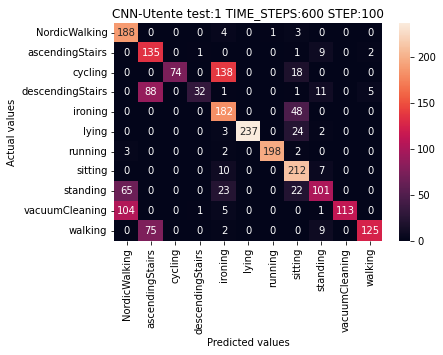

Utente test:  2
Training: x-> 11348 y-> 11348
Validation: x-> 2838 y-> 2838
Testing: x-> 2407 y-> 2407
Total: x-> 16593 y-> 16593
Epoch 1/100
89/89 [==============================] - 12s 125ms/step - loss: 1.8583 - accuracy: 0.4361 - f1_m: 0.3509 - val_loss: 0.9915 - val_accuracy: 0.6522 - val_f1_m: 0.5569
Epoch 2/100
89/89 [==============================] - 11s 123ms/step - loss: 0.8531 - accuracy: 0.6858 - f1_m: 0.6600 - val_loss: 0.6638 - val_accuracy: 0.7555 - val_f1_m: 0.7609
Epoch 3/100
89/89 [==============================] - 10s 116ms/step - loss: 0.6602 - accuracy: 0.7558 - f1_m: 0.7466 - val_loss: 0.5809 - val_accuracy: 0.7805 - val_f1_m: 0.7820
Epoch 4/100
89/89 [==============================] - 10s 116ms/step - loss: 0.5691 - accuracy: 0.7927 - f1_m: 0.7866 - val_loss: 0.4758 - val_accuracy: 0.8154 - val_f1_m: 0.8292
Epoch 5/100
89/89 [==============================] - 11s 123ms/step - loss: 0.5017 - accuracy: 0.8158 - f1_m: 0.8115 - val_loss: 0.4405 - val_accuracy: 0.8231

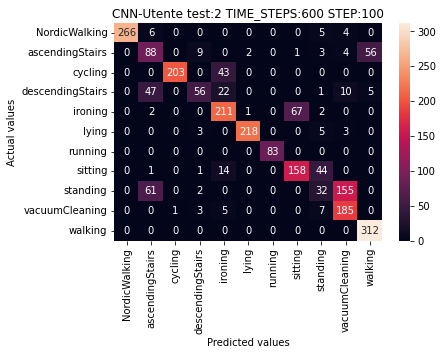

Utente test:  3
Training: x-> 11493 y-> 11493
Validation: x-> 2874 y-> 2874
Testing: x-> 2226 y-> 2226
Total: x-> 16593 y-> 16593
Epoch 1/100
90/90 [==============================] - 12s 129ms/step - loss: 1.7246 - accuracy: 0.4638 - f1_m: 0.3729 - val_loss: 0.8356 - val_accuracy: 0.6879 - val_f1_m: 0.6571
Epoch 2/100
90/90 [==============================] - 11s 124ms/step - loss: 0.8157 - accuracy: 0.6960 - f1_m: 0.6701 - val_loss: 0.5422 - val_accuracy: 0.7992 - val_f1_m: 0.7968
Epoch 3/100
90/90 [==============================] - 11s 124ms/step - loss: 0.6304 - accuracy: 0.7625 - f1_m: 0.7536 - val_loss: 0.4454 - val_accuracy: 0.8229 - val_f1_m: 0.8300
Epoch 4/100
90/90 [==============================] - 11s 118ms/step - loss: 0.5561 - accuracy: 0.7860 - f1_m: 0.7823 - val_loss: 0.5482 - val_accuracy: 0.7818 - val_f1_m: 0.7927
Epoch 5/100
90/90 [==============================] - 10s 117ms/step - loss: 0.4911 - accuracy: 0.8155 - f1_m: 0.8065 - val_loss: 0.4745 - val_accuracy: 0.8187

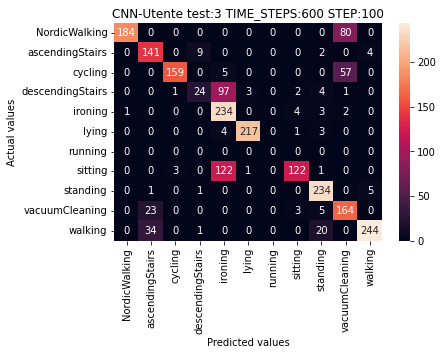

Utente test:  4
Training: x-> 11225 y-> 11225
Validation: x-> 2807 y-> 2807
Testing: x-> 2561 y-> 2561
Total: x-> 16593 y-> 16593
Epoch 1/100
88/88 [==============================] - 13s 135ms/step - loss: 1.8030 - accuracy: 0.4575 - f1_m: 0.3763 - val_loss: 0.9473 - val_accuracy: 0.6801 - val_f1_m: 0.5542
Epoch 2/100
88/88 [==============================] - 10s 118ms/step - loss: 0.8205 - accuracy: 0.7023 - f1_m: 0.6799 - val_loss: 0.5500 - val_accuracy: 0.7998 - val_f1_m: 0.7997
Epoch 3/100
88/88 [==============================] - 11s 124ms/step - loss: 0.6053 - accuracy: 0.7855 - f1_m: 0.7743 - val_loss: 0.4657 - val_accuracy: 0.8222 - val_f1_m: 0.8243
Epoch 4/100
88/88 [==============================] - 10s 118ms/step - loss: 0.4929 - accuracy: 0.8278 - f1_m: 0.8199 - val_loss: 0.4356 - val_accuracy: 0.8276 - val_f1_m: 0.8304
Epoch 5/100
88/88 [==============================] - 10s 118ms/step - loss: 0.4211 - accuracy: 0.8460 - f1_m: 0.8467 - val_loss: 0.3719 - val_accuracy: 0.8575

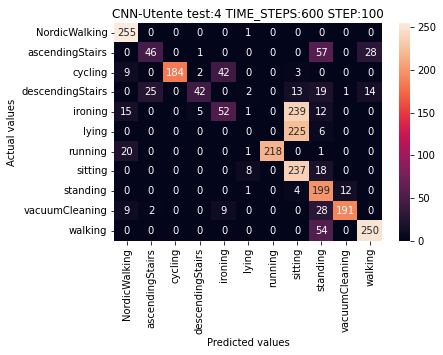

Utente test:  5
Training: x-> 11340 y-> 11340
Validation: x-> 2835 y-> 2835
Testing: x-> 2418 y-> 2418
Total: x-> 16593 y-> 16593
Epoch 1/100
89/89 [==============================] - 12s 128ms/step - loss: 1.8266 - accuracy: 0.4456 - f1_m: 0.3531 - val_loss: 0.8800 - val_accuracy: 0.6603 - val_f1_m: 0.6033
Epoch 2/100
89/89 [==============================] - 11s 124ms/step - loss: 0.8922 - accuracy: 0.6596 - f1_m: 0.6277 - val_loss: 0.6146 - val_accuracy: 0.7728 - val_f1_m: 0.7530
Epoch 3/100
89/89 [==============================] - 10s 117ms/step - loss: 0.6518 - accuracy: 0.7598 - f1_m: 0.7452 - val_loss: 0.4675 - val_accuracy: 0.8088 - val_f1_m: 0.8103
Epoch 4/100
89/89 [==============================] - 10s 117ms/step - loss: 0.5151 - accuracy: 0.8121 - f1_m: 0.8075 - val_loss: 0.4120 - val_accuracy: 0.8483 - val_f1_m: 0.8517
Epoch 5/100
89/89 [==============================] - 10s 117ms/step - loss: 0.4249 - accuracy: 0.8482 - f1_m: 0.8453 - val_loss: 0.3396 - val_accuracy: 0.8787

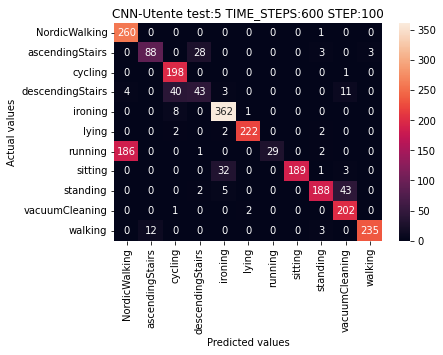

Utente test:  6
Training: x-> 11480 y-> 11480
Validation: x-> 2871 y-> 2871
Testing: x-> 2242 y-> 2242
Total: x-> 16593 y-> 16593
Epoch 1/100
90/90 [==============================] - 12s 126ms/step - loss: 1.7287 - accuracy: 0.4686 - f1_m: 0.3930 - val_loss: 0.8183 - val_accuracy: 0.7039 - val_f1_m: 0.6442
Epoch 2/100
90/90 [==============================] - 10s 116ms/step - loss: 0.8063 - accuracy: 0.7044 - f1_m: 0.6780 - val_loss: 0.6361 - val_accuracy: 0.7443 - val_f1_m: 0.7392
Epoch 3/100
90/90 [==============================] - 10s 117ms/step - loss: 0.6006 - accuracy: 0.7752 - f1_m: 0.7676 - val_loss: 0.4725 - val_accuracy: 0.8164 - val_f1_m: 0.8178
Epoch 4/100
90/90 [==============================] - 10s 116ms/step - loss: 0.4768 - accuracy: 0.8201 - f1_m: 0.8201 - val_loss: 0.4237 - val_accuracy: 0.8405 - val_f1_m: 0.8444
Epoch 5/100
90/90 [==============================] - 10s 116ms/step - loss: 0.4202 - accuracy: 0.8430 - f1_m: 0.8419 - val_loss: 0.3878 - val_accuracy: 0.8541

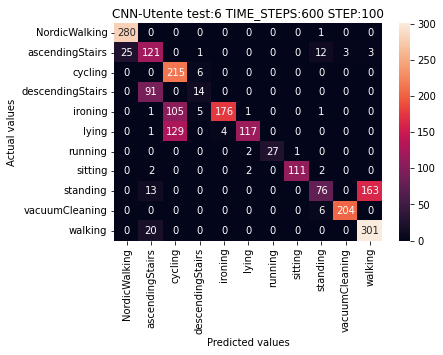

Utente test:  7
Training: x-> 11313 y-> 11313
Validation: x-> 2829 y-> 2829
Testing: x-> 2451 y-> 2451
Total: x-> 16593 y-> 16593
Epoch 1/100
89/89 [==============================] - 12s 122ms/step - loss: 1.8094 - accuracy: 0.4406 - f1_m: 0.3545 - val_loss: 0.9261 - val_accuracy: 0.6932 - val_f1_m: 0.5822
Epoch 2/100
89/89 [==============================] - 10s 116ms/step - loss: 0.8884 - accuracy: 0.6698 - f1_m: 0.6374 - val_loss: 0.6682 - val_accuracy: 0.7398 - val_f1_m: 0.7378
Epoch 3/100
89/89 [==============================] - 10s 116ms/step - loss: 0.6588 - accuracy: 0.7569 - f1_m: 0.7457 - val_loss: 0.5633 - val_accuracy: 0.7777 - val_f1_m: 0.7884
Epoch 4/100
89/89 [==============================] - 10s 116ms/step - loss: 0.5617 - accuracy: 0.7930 - f1_m: 0.7869 - val_loss: 0.4715 - val_accuracy: 0.8180 - val_f1_m: 0.8213
Epoch 5/100
89/89 [==============================] - 10s 115ms/step - loss: 0.4785 - accuracy: 0.8290 - f1_m: 0.8236 - val_loss: 0.5334 - val_accuracy: 0.7975

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


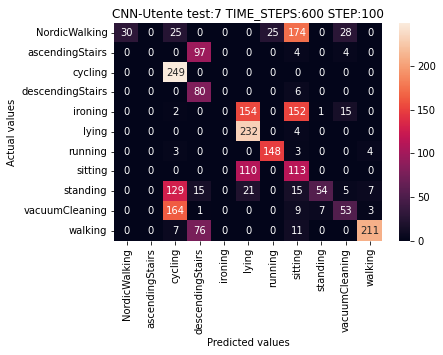

Accuracy media: 0.7031376817379716
F1 weighted media: 0.6793688415493273
F1 macro media: 0.6681834984937226
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.703138             0.679369          0.668183   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [44]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


In [45]:
print(np.unique(y_pred))
print(np.unique(y_test))

[ 0  2  3  5  6  7  8  9 10]
[0. 1.]


# Bi-LSTM

In [46]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [47]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [48]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1
Epoch 1/100
90/90 [==============================] - 19s 136ms/step - loss: 1.3441 - accuracy: 0.5289 - val_loss: 0.8030 - val_accuracy: 0.7106
Epoch 2/100
90/90 [==============================] - 11s 120ms/step - loss: 0.7320 - accuracy: 0.7464 - val_loss: 0.5136 - val_accuracy: 0.8085
Epoch 3/100
90/90 [==============================] - 11s 120ms/step - loss: 0.5884 - accuracy: 0.7949 - val_loss: 0.3881 - val_accuracy: 0.8703
Epoch 4/100
90/90 [==============================] - 11s 120ms/step - loss: 0.5434 - accuracy: 0.8188 - val_loss: 0.3352 - val_accuracy: 0.8840
Epoch 5/100
90/90 [==============================] - 11s 120ms/step - loss: 0.5586 - accuracy: 0.8038 - val_loss: 0.3281 - val_accuracy: 0.8951
Epoch 6/100
90/90 [==============================] - 11s 120ms/step - loss: 0.4115 - accuracy: 0.8625 - val_loss: 0.3650 - val_accuracy: 0.8763
Epoch 7/100
90/90 [==============================] - 12s 136ms/step - loss: 0.4270 - accuracy: 0.8505 - val_loss

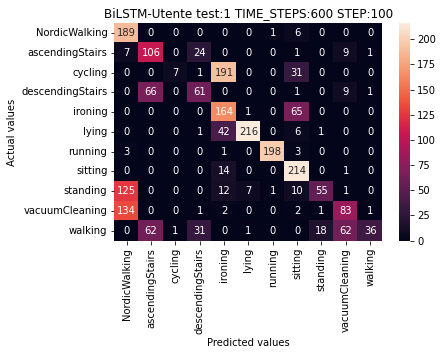

Utente test:  2
Epoch 1/100
89/89 [==============================] - 18s 137ms/step - loss: 1.4370 - accuracy: 0.4907 - val_loss: 0.7465 - val_accuracy: 0.7227
Epoch 2/100
89/89 [==============================] - 11s 121ms/step - loss: 0.7833 - accuracy: 0.7233 - val_loss: 0.5209 - val_accuracy: 0.8147
Epoch 3/100
89/89 [==============================] - 11s 119ms/step - loss: 0.6808 - accuracy: 0.7616 - val_loss: 0.5342 - val_accuracy: 0.8062
Epoch 4/100
89/89 [==============================] - 11s 118ms/step - loss: 0.6145 - accuracy: 0.7905 - val_loss: 0.4908 - val_accuracy: 0.8224
Epoch 5/100
89/89 [==============================] - 11s 119ms/step - loss: 0.5232 - accuracy: 0.8217 - val_loss: 0.4058 - val_accuracy: 0.8573
Epoch 6/100
89/89 [==============================] - 11s 120ms/step - loss: 0.4345 - accuracy: 0.8493 - val_loss: 0.3069 - val_accuracy: 0.8851
Epoch 7/100
89/89 [==============================] - 11s 120ms/step - loss: 0.3643 - accuracy: 0.8736 - val_loss: 0.4087

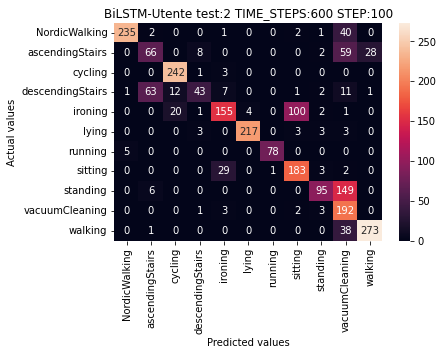

Utente test:  3
Epoch 1/100
90/90 [==============================] - 18s 134ms/step - loss: 1.3727 - accuracy: 0.5187 - val_loss: 0.7678 - val_accuracy: 0.7133
Epoch 2/100
90/90 [==============================] - 11s 119ms/step - loss: 0.7700 - accuracy: 0.7301 - val_loss: 0.6558 - val_accuracy: 0.7721
Epoch 3/100
90/90 [==============================] - 11s 119ms/step - loss: 0.5808 - accuracy: 0.7982 - val_loss: 0.5034 - val_accuracy: 0.8128
Epoch 4/100
90/90 [==============================] - 11s 119ms/step - loss: 0.5601 - accuracy: 0.8047 - val_loss: 0.3921 - val_accuracy: 0.8619
Epoch 5/100
90/90 [==============================] - 11s 118ms/step - loss: 0.5586 - accuracy: 0.8157 - val_loss: 0.4866 - val_accuracy: 0.8264
Epoch 6/100
90/90 [==============================] - 11s 118ms/step - loss: 0.6380 - accuracy: 0.7754 - val_loss: 0.5010 - val_accuracy: 0.8170
Epoch 7/100
90/90 [==============================] - 11s 118ms/step - loss: 0.6398 - accuracy: 0.7788 - val_loss: 0.4915

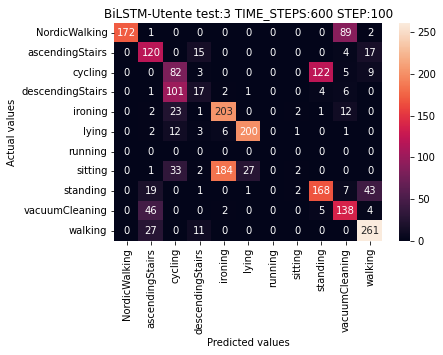

Utente test:  4
Epoch 1/100
88/88 [==============================] - 18s 134ms/step - loss: 1.3633 - accuracy: 0.5201 - val_loss: 0.7659 - val_accuracy: 0.7321
Epoch 2/100
88/88 [==============================] - 10s 117ms/step - loss: 0.7988 - accuracy: 0.7125 - val_loss: 0.5572 - val_accuracy: 0.7937
Epoch 3/100
88/88 [==============================] - 10s 118ms/step - loss: 0.6668 - accuracy: 0.7665 - val_loss: 0.4811 - val_accuracy: 0.8315
Epoch 4/100
88/88 [==============================] - 10s 118ms/step - loss: 0.6040 - accuracy: 0.7931 - val_loss: 0.7161 - val_accuracy: 0.7456
Epoch 5/100
88/88 [==============================] - 10s 118ms/step - loss: 0.6131 - accuracy: 0.7886 - val_loss: 0.4367 - val_accuracy: 0.8411
Epoch 6/100
88/88 [==============================] - 10s 117ms/step - loss: 0.5114 - accuracy: 0.8269 - val_loss: 0.4778 - val_accuracy: 0.8365
Epoch 7/100
88/88 [==============================] - 10s 117ms/step - loss: 0.4851 - accuracy: 0.8381 - val_loss: 0.3725

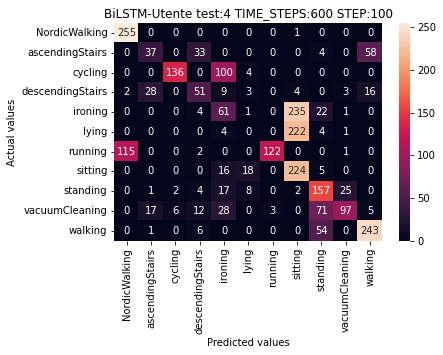

Utente test:  5
Epoch 1/100
89/89 [==============================] - 18s 140ms/step - loss: 1.4255 - accuracy: 0.4802 - val_loss: 0.8178 - val_accuracy: 0.6899
Epoch 2/100
89/89 [==============================] - 11s 124ms/step - loss: 0.8396 - accuracy: 0.6946 - val_loss: 0.5971 - val_accuracy: 0.7799
Epoch 3/100
89/89 [==============================] - 11s 123ms/step - loss: 0.6560 - accuracy: 0.7673 - val_loss: 0.4568 - val_accuracy: 0.8205
Epoch 4/100
89/89 [==============================] - 11s 123ms/step - loss: 0.6121 - accuracy: 0.7840 - val_loss: 0.6723 - val_accuracy: 0.7256
Epoch 5/100
89/89 [==============================] - 11s 124ms/step - loss: 0.7055 - accuracy: 0.7399 - val_loss: 0.4860 - val_accuracy: 0.8053
Epoch 6/100
89/89 [==============================] - 11s 124ms/step - loss: 0.6058 - accuracy: 0.7837 - val_loss: 0.6681 - val_accuracy: 0.7513
Epoch 7/100
89/89 [==============================] - 11s 124ms/step - loss: 0.5282 - accuracy: 0.8051 - val_loss: 0.3694

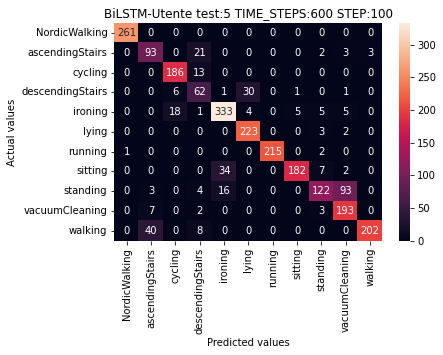

Utente test:  6
Epoch 1/100
90/90 [==============================] - 19s 141ms/step - loss: 1.3572 - accuracy: 0.5161 - val_loss: 0.7138 - val_accuracy: 0.7443
Epoch 2/100
90/90 [==============================] - 11s 126ms/step - loss: 0.7903 - accuracy: 0.7171 - val_loss: 0.5285 - val_accuracy: 0.8168
Epoch 3/100
90/90 [==============================] - 11s 123ms/step - loss: 0.7236 - accuracy: 0.7461 - val_loss: 0.5141 - val_accuracy: 0.8175
Epoch 4/100
90/90 [==============================] - 11s 123ms/step - loss: 0.5737 - accuracy: 0.7924 - val_loss: 0.4639 - val_accuracy: 0.8346
Epoch 5/100
90/90 [==============================] - 11s 123ms/step - loss: 0.6004 - accuracy: 0.7997 - val_loss: 0.5334 - val_accuracy: 0.8123
Epoch 6/100
90/90 [==============================] - 11s 124ms/step - loss: 0.5809 - accuracy: 0.8013 - val_loss: 0.4699 - val_accuracy: 0.8276
Epoch 7/100
90/90 [==============================] - 11s 124ms/step - loss: 0.5002 - accuracy: 0.8294 - val_loss: 0.4001

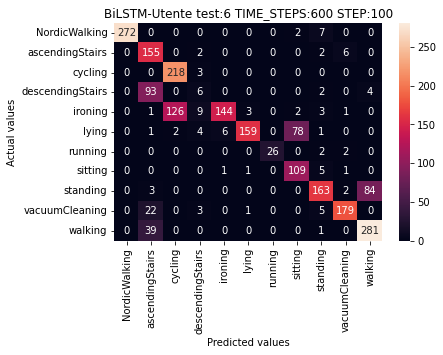

Utente test:  7
Epoch 1/100
89/89 [==============================] - 19s 143ms/step - loss: 1.4051 - accuracy: 0.5037 - val_loss: 0.7534 - val_accuracy: 0.7165
Epoch 2/100
89/89 [==============================] - 11s 125ms/step - loss: 0.8385 - accuracy: 0.6919 - val_loss: 0.5569 - val_accuracy: 0.7731
Epoch 3/100
89/89 [==============================] - 11s 127ms/step - loss: 0.6981 - accuracy: 0.7467 - val_loss: 0.4904 - val_accuracy: 0.8112
Epoch 4/100
89/89 [==============================] - 11s 128ms/step - loss: 0.6647 - accuracy: 0.7673 - val_loss: 0.4518 - val_accuracy: 0.8317
Epoch 5/100
89/89 [==============================] - 11s 129ms/step - loss: 0.5796 - accuracy: 0.7965 - val_loss: 0.6253 - val_accuracy: 0.7815
Epoch 6/100
89/89 [==============================] - 11s 126ms/step - loss: 0.6739 - accuracy: 0.7688 - val_loss: 0.4395 - val_accuracy: 0.8332
Epoch 7/100
89/89 [==============================] - 12s 139ms/step - loss: 0.5193 - accuracy: 0.8195 - val_loss: 0.3680

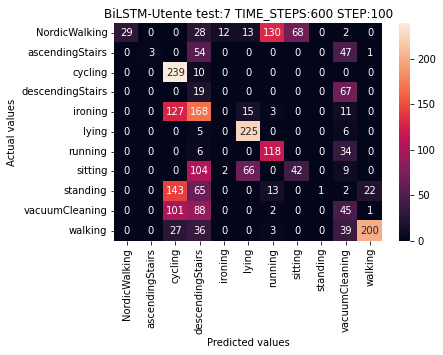

Accuracy media: 0.6383655582597951
F1 media macro: 0.5979941142266113
F1 media weighted: 0.5979941142266113


In [49]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:

            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if id != user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

            model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
            bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            bilstm_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

            bilstm_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [50]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.638366,0.615031,0.597994,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [51]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.8s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.34      0.64      0.45       196
 ascendingStairs       0.43      0.89      0.58       148
         cycling       0.00      0.00      0.00       230
descendingStairs       0.12      0.05      0.07       138
         ironing       0.42      0.93      0.58       230
           lying       0.87      0.92      0.89       266
         running       1.00      0.95      0.97       205
         sitting       0.91      0.53      0.67       229
        standing       0.84      0.40      0.54       211
  vacuumCleaning       0.44      0.53      0.48       224
         walking       1.00      0.33      0.49       211

        accuracy                           0.57      2288
       macro avg       0.58      0.56      0.52      2288
    weighted avg       0.60      0.57      0.54      2288

f1:  0.5394500723681506
acc:  0.5729895104895105


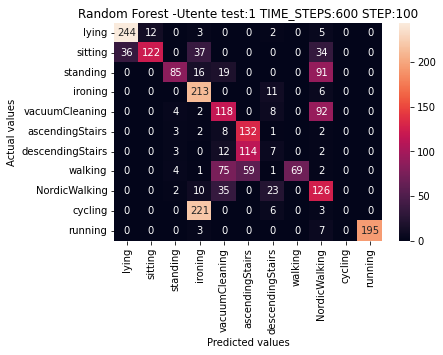

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))